In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import mahotas as mt
import skimage.feature as ftr
import skimage.io
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Função extração de Caracteriísticas


In [2]:
def extract_features(roi):
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(roi)
    
    # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    
    return ht_mean

### Buscar Maior Contorno

In [3]:
def findGreatesContour(contours):
    largest_area = 0
    largest_contour_index = -1
    i = 0
    total_contours = len(contours)
    while (i < total_contours ):
        
        area = cv2.contourArea(contours[i])
        
        if(area > largest_area):
            largest_area = area
            largest_contour_index = i
        
        i+=1
            
    return largest_area, largest_contour_index

### Buscar Feature Imagem com caminho

In [4]:
def getImageFeatures(path):
    
    image = cv2.imread(path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    bilateralFilter = cv2.bilateralFilter(gray, 9, 100, 100)

    thresh = cv2.threshold(bilateralFilter, 150, 200, cv2.THRESH_BINARY)[1]

    thresh = cv2.erode(thresh, None, iterations=2)

    thresh = cv2.dilate(thresh, None, iterations=2)

    _, contours, hierarchy =  cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0 :
        largest_area, largest_contour_index = findGreatesContour(contours)
        
        x, y, w, h = cv2.boundingRect(contours[largest_contour_index])
        roi = image[y:y+h, x:x+w]
    else:
        # it's need to process non tumour presence so we extract 
        # features from the image itself
        roi = image
    
    grayROI = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    features = extract_features(grayROI)

    return features

### Mostrar gráfico SVM

In [5]:
def plot_data(x,y,xlabel,ylabel,pos_label,neg_label,axes = None):
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    
    plt.rcParams['figure.figsize'] = (20,14) 
    
    pos = y[:] == 1
    neg = y[:] == 0
    
    if axes == None:
        axes = plt.gca()
        
    axes.scatter(x[pos][:,0],x[pos][:,5],marker='o', c='#003f5c', s=50, linewidth= 2, label = pos_label)
    axes.scatter(x[neg][:,0],x[neg][:,5],marker='o', c='#ffa600', s=50, linewidth= 2, label = neg_label)
    
    axes.set_xlim([xmin,xmax])
    axes.set_xlim([ymin,ymax])
    
    axes.set_xlabel(xlabel, fontsize = 20)
    axes.set_ylabel(ylabel, fontsize = 20)
    
    axes.legend(bbox_to_anchor = (1,1), fancybox=True)

### Percorrendo as imagens e extraindo as características

In [6]:
labels = {'yes': 1, 'no':0}
df = pd.DataFrame()
files = []

In [7]:
for s in ('yes', 'no'):
    path = './img/%s' % s

    for file in os.listdir(path):
        if '.jpg' or '.jpeg' in file:
            filename = os.path.join(path, file)

            print("Processing file %s" % filename)
            
            files.append(filename)

            features = getImageFeatures(filename)
            
            row = np.array(features)
            
            row = np.append(row, [labels[s]])

            df = df.append(pd.Series(row), ignore_index=True)

Processing file ./img/yes\Y1.jpg
Processing file ./img/yes\Y10.jpg
Processing file ./img/yes\Y100.JPG
Processing file ./img/yes\Y101.jpg
Processing file ./img/yes\Y102.jpg
Processing file ./img/yes\Y103.jpg
Processing file ./img/yes\Y104.jpg
Processing file ./img/yes\Y105.jpg
Processing file ./img/yes\Y106.jpg
Processing file ./img/yes\Y107.jpg
Processing file ./img/yes\Y108.jpg
Processing file ./img/yes\Y109.JPG
Processing file ./img/yes\Y11.jpg
Processing file ./img/yes\Y111.JPG
Processing file ./img/yes\Y112.JPG
Processing file ./img/yes\Y113.JPG
Processing file ./img/yes\Y114.JPG
Processing file ./img/yes\Y115.JPG
Processing file ./img/yes\Y116.JPG
Processing file ./img/yes\Y117.JPG
Processing file ./img/yes\Y12.jpg
Processing file ./img/yes\Y120.JPG
Processing file ./img/yes\Y13.jpg
Processing file ./img/yes\Y14.jpg
Processing file ./img/yes\Y146.JPG
Processing file ./img/yes\Y147.JPG
Processing file ./img/yes\Y148.JPG
Processing file ./img/yes\Y15.jpg
Processing file ./img/yes\Y1

Processing file ./img/no\no9.png
Processing file ./img/no\no90.jpg
Processing file ./img/no\no91.jpeg
Processing file ./img/no\no92.jpg
Processing file ./img/no\no923.jpg
Processing file ./img/no\no94.jpg
Processing file ./img/no\no95.jpg
Processing file ./img/no\no96.jpg
Processing file ./img/no\no97.jpg
Processing file ./img/no\no98.jpg
Processing file ./img/no\no99.jpg


In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000548,261.042117,0.939045,2154.787280,0.160593,385.723778,8358.107003,7.951493,11.425902,0.000228,4.601950,-0.373785,0.997254,1.0
1,0.015888,281.037837,0.965444,4074.733091,0.334166,218.482325,16017.894525,7.767939,11.134109,0.000378,4.300001,-0.396115,0.997711,1.0
2,0.000972,990.232964,0.840808,3136.514202,0.085864,338.136177,11555.823845,7.819911,10.166990,0.000100,5.650934,-0.576493,0.999864,1.0
3,0.004621,625.152913,0.937178,4969.905535,0.298722,161.784503,19254.469227,7.570962,10.322259,0.000338,4.588177,-0.421844,0.997839,1.0
4,0.000564,55.118392,0.992571,3710.578318,0.205789,307.602403,14787.194879,8.568080,12.032104,0.000315,3.921422,-0.413829,0.998985,1.0


In [9]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
248,0.051882,881.597753,0.932307,6509.056685,0.352663,161.562924,25154.628986,7.044754,9.302439,0.000381,4.730311,-0.467053,0.998132,0.0
249,0.001615,100.877457,0.970121,1688.613258,0.316517,163.980014,6653.575576,7.493744,10.600146,0.000494,3.597037,-0.371360,0.995576,0.0
250,0.003039,222.794782,0.961650,2905.431773,0.324798,189.405626,11398.932309,7.512243,10.677223,0.000440,3.932692,-0.366312,0.995466,0.0
251,0.018445,130.938538,0.981568,3552.610440,0.348969,169.119295,14079.503224,7.042729,9.353333,0.000658,3.269085,-0.447053,0.997486,0.0
252,0.063505,213.626012,0.966672,3204.539180,0.392330,107.744047,12604.530707,6.687682,9.325263,0.000489,4.009925,-0.399184,0.995033,0.0


In [10]:
df.shape

(253, 14)

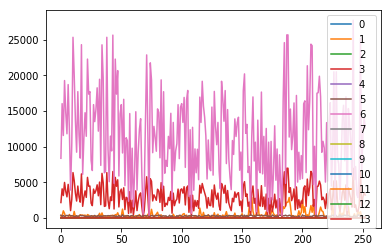

In [11]:
df.plot(kind='line')

### Separando dados de treino e teste

In [12]:
X = df.iloc[:, 0:12]
y = df.iloc[:, 13]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
filename = './raw_data_trained_model.sav'
pickle.dump(svm, open(filename, 'wb'))

### Função mostrar precisão

In [17]:
def displayModelPerformance(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

In [18]:
displayModelPerformance(svm, X_test, y_test)

Misclassified samples: 14
Accuracy: 0.82


### Dados Standarizados

In [19]:
sc = StandardScaler()
sc.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
filename = './data_Standard_Model.sav'
pickle.dump(sc, open(filename, 'wb'))

In [22]:
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

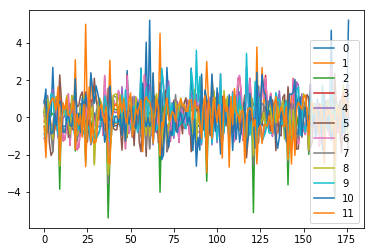

In [23]:
scaled_df = pd.DataFrame(X_train_std)
scaled_df.plot(kind='line')

In [24]:
svm = SVC(kernel='linear',C= 0.2)
svm.fit(X_train_std, y_train)

SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [25]:
filename = './optimised_model.sav'
pickle.dump(svm, open(filename, 'wb'))

In [26]:
displayModelPerformance(svm, X_test_std, y_test)

Misclassified samples: 12
Accuracy: 0.84


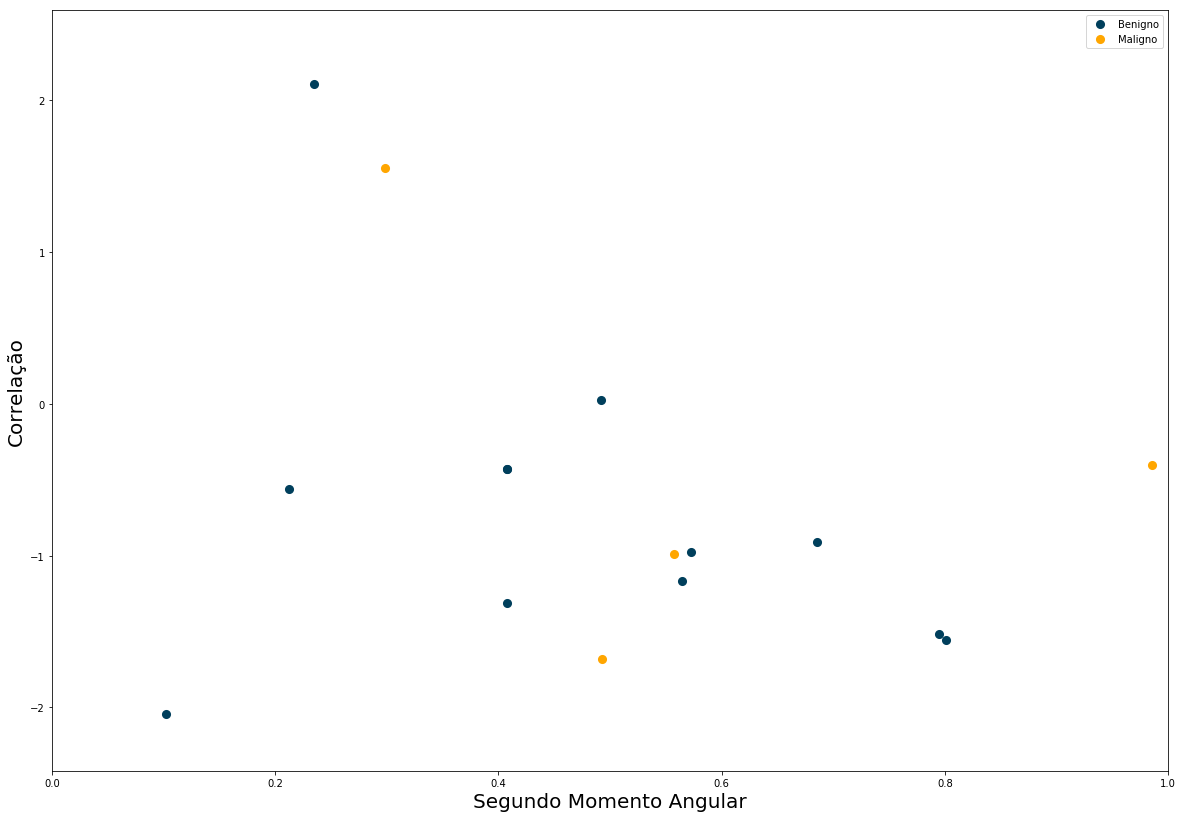

In [27]:
plot_data(X_train_std,y_train,'Segundo Momento Angular','Correlação','Benigno','Maligno')

In [28]:
sigma = [0.01,0.03,0.1,0.3,1,3,10,38]
C = [0.01,0.83,0.1,0.3,1,3,10,30]


erros = list()
sigma_c = list()


for each_c in C:
    clf = SVC(kernel='linear',C = each_c)
    clf.fit(X_train_std,y_train)
    print('\nC:' + str(each_c) + '\nPERFORMANCE:' + str(displayModelPerformance(clf, X_test_std, y_test)))        

Misclassified samples: 18
Accuracy: 0.76

C:0.01
PERFORMANCE:None
Misclassified samples: 13
Accuracy: 0.83

C:0.83
PERFORMANCE:None
Misclassified samples: 14
Accuracy: 0.82

C:0.1
PERFORMANCE:None
Misclassified samples: 12
Accuracy: 0.84

C:0.3
PERFORMANCE:None
Misclassified samples: 13
Accuracy: 0.83

C:1
PERFORMANCE:None
Misclassified samples: 14
Accuracy: 0.82

C:3
PERFORMANCE:None
Misclassified samples: 14
Accuracy: 0.82

C:10
PERFORMANCE:None
Misclassified samples: 15
Accuracy: 0.80

C:30
PERFORMANCE:None


In [29]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_train_std, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
displayModelPerformance(svm, X_test_std, y_test)

Misclassified samples: 18
Accuracy: 0.76


In [31]:
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
displayModelPerformance(svm, X_test_std, y_test)

Misclassified samples: 29
Accuracy: 0.62


In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

C:\Users\MrDelicia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [35]:
displayModelPerformance(lr, X_test_std, y_test)

Misclassified samples: 12
Accuracy: 0.84
